# Amazon Fine Food Reviews Preprocessing

This IPython notebook consists code for preprocessing of text, conversion of text into vectors and saving that information for further use.

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

## Public Information - 

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.
  1. Number of reviews: 568,454
  2. Number of users: 256,059
  3. Number of products: 74,258
  4. Timespan: Oct 1999 - Oct 2012
  5. Number of Attributes/Columns in data: 10

### Attribute Information -

  1. Id
  2. ProductId - unique identifier for the product
  3. UserId - unqiue identifier for the user
  4. ProfileName
  5. HelpfulnessNumerator - number of users who found the review helpful
  6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
  7. Score - rating between 1 and 5
  8. Time - timestamp for the review
  9. Summary - brief summary of the review
  10. Text - text of the review

### Current Objective - 
  Go through the reviews and perform preprocessing, convert them into vectors and save them for future use.


## Let's start with importing necessary libraries

In [1]:
#importing necessary libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import missingno as msno
import pickle

import re
import os
#os.getcwd()
dir_path = os.path.abspath(os.path.join(os.getcwd(), '..'))

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import KeyedVectors

In [2]:
#connecting to sqlite db
con = sqlite3.connect(os.path.join(dir_path, 'datasets','amzn_fine_food_reviews', 'database.sqlite'))

#filtering only positive and negative reviews
data = pd.read_sql_query("SELECT * FROM Reviews WHERE Score != 3", con)

print("Shape of data:", data.shape)

#scores < 3 are considered to be negative reviews and > 3 are considered to be positive reviews
data.head()

Shape of data: (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Missing values? Yeah, it happens...

Missing values? Ans - False


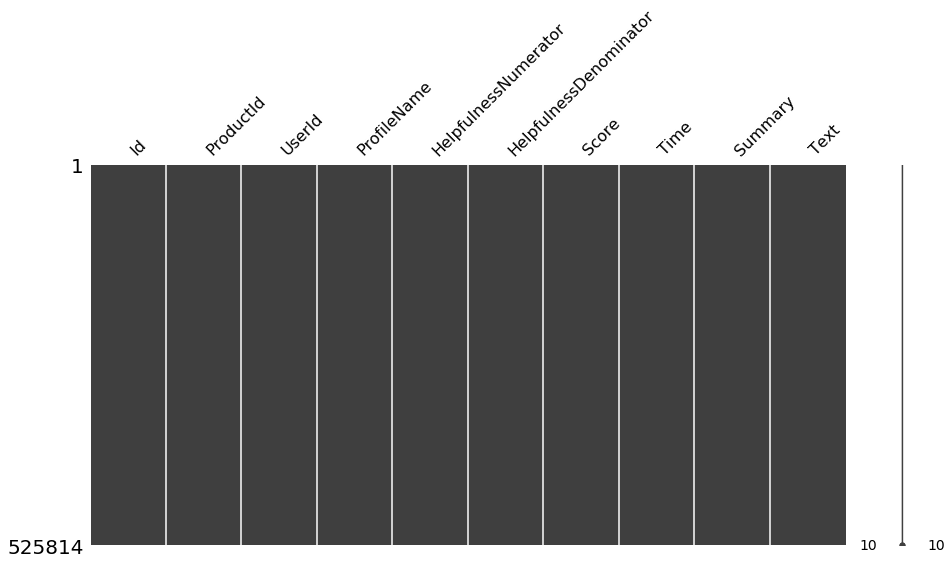

In [3]:
#let's just check, just in case if any
print("Missing values? Ans -", data.isnull().values.any())

#visualizing it
msno.matrix(data, figsize=(15,7))

## One can write more than one review for the same product!

In [4]:
df = data.copy()
df['ProdUser'] = df['ProductId'] + df['UserId']
df[df['ProdUser'].duplicated(keep=False)].sort_values('ProdUser', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProdUser
157863,171174,7310172001,AE9ZBY7WW3LIQ,W. K. Ota,0,0,4,1182902400,Best snack item for my dog.,Otter and I are very happy with this product. ...,7310172001AE9ZBY7WW3LIQ
157871,171183,7310172001,AE9ZBY7WW3LIQ,W. K. Ota,5,13,1,1219363200,Why sbould I get crums?,I selected this company over the other even th...,7310172001AE9ZBY7WW3LIQ
157912,171228,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",5,7,5,1233360000,NO waste at all--- all dogs love liver treats-...,Freeze dried liver has a hypnotic effect on do...,7310172001AJD41FBJD9010
157841,171152,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",0,0,5,1233360000,dogs LOVE it-- best treat for rewards and tra...,Freeze dried liver has a hypnotic effect on do...,7310172001AJD41FBJD9010
157842,171153,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",0,0,5,1233360000,best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...,7310172001AJD41FBJD9010
157843,171154,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",0,0,5,1233360000,best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...,7310172001AJD41FBJD9010
157876,171189,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",39,51,5,1233360000,NO waste at all ---- great for training ----...,Freeze dried liver has a hypnotic effect on do...,7310172001AJD41FBJD9010
157908,171223,7310172001,AJD41FBJD9010,"N. Ferguson ""Two, Daisy, Hannah, and Kitten""",1,1,5,1233360000,best dog treat-- great for training--- all do...,Freeze dried liver has a hypnotic effect on do...,7310172001AJD41FBJD9010
200626,217414,7310172101,AE9ZBY7WW3LIQ,W. K. Ota,5,13,1,1219363200,Why sbould I get crums?,I selected this company over the other even th...,7310172101AE9ZBY7WW3LIQ
200618,217405,7310172101,AE9ZBY7WW3LIQ,W. K. Ota,0,0,4,1182902400,Best snack item for my dog.,Otter and I are very happy with this product. ...,7310172101AE9ZBY7WW3LIQ


### Obeservations

1.   There are some instances where a user has written more than one review for the same product.
2.   We can remove the one which has less Helpfulness but lets keep all and treat it as review from a different user.
3.   Will definitely have to remove same reviews because it is just redundant data.



In [5]:
#Sorting data according to ProductId in ascending order
data = data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#print("##")

In [6]:
#Deduplication of entries (364173, 10)
data=data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
data.shape

(364173, 10)

In [7]:
data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,4,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."


## Same reviews on multiple products with different timestamps!!

In [8]:
data[data['Text'].duplicated(keep=False)].sort_values('Text', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
67574,73444,B0046IISFG,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",1,1,5,1342915200,Great Diabetic Friendly Sweetwner - Highly Rec...,"""Erythritol"" has become one of our favorite su..."
287090,311004,B001EO6FPU,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",9,9,5,1297036800,Great Diabetic Friendly Sweetener - Highly Rec...,"""Erythritol"" has become one of our favorite su..."
302818,327982,B0000CEQ6H,A281NPSIMI1C2R,"Rebecca of Amazon ""The Rebecca Review""",3,3,5,1084492800,Superior for Bread Baking,"""We use and believe in stone milling because n..."
494235,534333,B0000CEQ72,A281NPSIMI1C2R,"Rebecca of Amazon ""The Rebecca Review""",1,1,5,1093651200,Bob's Red Mill Whole Wheat Flour,"""We use and believe in stone milling because n..."
387315,418839,B000FZYSVC,A1YUL9PCJR3JTY,"O. Brown ""Ms. O. Khannah-Brown""",1,1,5,1173052800,Perfect Morning Tea (Caffeinated),*****<br /><br />Numi Tea's Chinese Breakfast ...
164025,177904,B000PSFW9Q,A1YUL9PCJR3JTY,"O. Brown ""Ms. O. Khannah-Brown""",1,1,5,1156723200,Perfect Morning Tea (Caffeinated),*****<br /><br />Numi Tea's Chinese Breakfast ...
267899,290387,B000S85AVI,A1YUL9PCJR3JTY,"O. Brown ""Ms. O. Khannah-Brown""",2,2,5,1173052800,Golden Chai Must Be Experienced!,*****<br /><br />Numi Tea's Golden Chai Spiced...
443822,479891,B000Z91YTC,A1YUL9PCJR3JTY,"O. Brown ""Ms. O. Khannah-Brown""",6,6,5,1156723200,Golden Chai Must Be Experienced!,*****<br /><br />Numi Tea's Golden Chai Spiced...
442191,478132,B0001GSP9G,A1YUL9PCJR3JTY,"O. Brown ""Ms. O. Khannah-Brown""",1,1,5,1156723200,Superb Black Tea Blend (Caffeinated),*****<br /><br />Numi Tea's Morning Rise Break...
177373,192340,B000M7OWLE,A1YUL9PCJR3JTY,"O. Brown ""Ms. O. Khannah-Brown""",1,1,5,1173052800,Superb Black Tea Blend (Caffeinated),*****<br /><br />Numi Tea's Morning Rise Break...


In [9]:
#removing duplicate reviews
data=data.drop_duplicates(subset={"Text"}, keep='first', inplace=False)
data.shape

(363836, 10)

### Observations

1.   There are reviews which are same on similar products (mostly different flavors). 
2.   These reviews were posted with different timestamps by the same person (weird).
3.   Since we are interested in a review being positive or negative, having redundant reviews makes no sense, so removing them.



In [10]:
#also removing those reviews where HelpfulnessNumerator is greater than HelpfulnessDenominator which is not possible
data=data[data['HelpfulnessNumerator']<=data['HelpfulnessDenominator']]
data.shape

(363834, 10)

## Now, it's time for some Text Preprocessing

We will be doing the following in order.

1.   Text cleaning - includes removal of special characters which are not required.
2.   Check if the word is actually an English word.
3.   Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
4.   Convert the word to lower case.
5.   Remove stop words but let's keep words like 'not' which makes the sentence negative.
6.   POS Tagging and WordNet Lemmatizing the word.



In [11]:
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [12]:
stop = list(set(stopwords.words('english'))) #set of stopwords
print(stop)

#removing words like 'not' that gives negative meaning to a sentence from stopwords
important_stopwords = ['hadn', 'weren', 'shouldn', "needn't", 'needn', 'doesn', "shan't", "shouldn't", "wasn", "couldn't", 'mustn', "hadn't", "doesn't",
                      'wouldn', "weren't", "didn", "mustn't", "wasn't", "didn't", "don't", "not"]
pre_final_stops = [x for x in stop if x not in important_stopwords]

#removing punctuation from stop words
final_stops = list(set([cleanpunc(x) for x in pre_final_stops]))
print("Final stopwords:", final_stops)

['no', 'through', 'them', 'nor', 'will', 'shouldn', 'the', "needn't", "wasn't", 'having', 'down', "you'll", 'he', "should've", 'this', 'about', 'being', 'these', 'most', 'my', 'doing', 'between', "you're", 'a', 'isn', "you've", 'haven', 'i', 'who', 'up', 'should', 't', 'her', 'to', 'hasn', 'on', 'yours', 'didn', 'same', 'here', "she's", 'theirs', 'above', 'then', 'too', 'your', 'and', 'some', 'only', 'don', 'before', 'few', 'has', 'during', "shouldn't", 'but', 'been', "couldn't", 'so', 'by', 'under', 'now', 'o', 'ain', "you'd", 'can', 'because', 'into', 'myself', 'do', 'whom', "won't", 'wasn', 'doesn', 'more', 'at', 'yourselves', 'did', 'those', 'after', 'ours', 'below', 'against', 're', 'does', 'shan', 'd', 'just', 'him', 'when', 'why', 'again', 'be', 'itself', "isn't", 'herself', 'wouldn', 'you', 'over', 'off', 'his', 'any', 'what', 'had', 'further', 'needn', 'themselves', 'was', 'of', 'with', 'than', 'couldn', "doesn't", 'she', 'an', 'll', "mustn't", 'hers', 'very', 've', 'in', "it'

In [13]:
#creating word net lemmatizer object
wnl = WordNetLemmatizer()

In [14]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
scores = data['Score'].values
for sent in data['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    tokens = pos_tag(word_tokenize(sent))
    for w in tokens:
        for cleaned_words in cleanpunc(w[0]).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    #s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    # lemmatization works better with POS tagging
                    tag = w[1][0].lower()
                    tag = tag if tag in ['a', 'n', 'v'] else None
                    if not tag:
                        s = cleaned_words.lower().encode('utf8')
                    else:
                        s = wnl.lemmatize(cleaned_words.lower(), tag).lower().encode("utf8")
                    filtered_sentence.append(s)
                    if scores[i] > 3: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if scores[i] < 3:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1
print("Done!")

Done!


In [15]:
data['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
data['CleanedText']=data['CleanedText'].str.decode("utf-8")

In [16]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect(os.path.join(dir_path, 'datasets','amzn_fine_food_reviews', 'final.sqlite'))
c=conn.cursor()
conn.text_factory = str
data.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [17]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(data['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (363834, 90825)
the number of unique words  90825


In [18]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'like', 137224), (b'taste', 122048), (b'good', 111392), (b'love', 104941), (b'great', 103358), (b'use', 101467), (b'make', 100402), (b'flavor', 99414), (b'one', 96800), (b'get', 93102), (b'product', 90812), (b'try', 86223), (b'tea', 82861), (b'coffee', 78958), (b'find', 78423), (b'buy', 75963), (b'food', 64946), (b'would', 59997), (b'eat', 57441), (b'time', 54081)]
Most Common Negative Words :  [(b'taste', 33523), (b'like', 31734), (b'product', 28122), (b'buy', 20800), (b'one', 20593), (b'would', 20028), (b'get', 20000), (b'flavor', 18124), (b'try', 17575), (b'make', 16240), (b'use', 14915), (b'good', 14894), (b'coffee', 14764), (b'order', 12792), (b'food', 12756), (b'think', 11931), (b'tea', 11634), (b'eat', 11014), (b'even', 10947), (b'box', 10812)]


In [19]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(data['CleanedText'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (363834, 3165502)
the number of unique words including both unigrams and bigrams  3165502


In [3]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(data['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (363834, 3165502)
the number of unique words including both unigrams and bigrams  3165502


In [21]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[100000:100010])

some sample features(unique words in the corpus) ['amount push', 'amount put', 'amount pyrithione', 'amount quail', 'amount quaker', 'amount qualify', 'amount quality', 'amount quandry', 'amount quantity', 'amount quart']


In [22]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

In [23]:
top_tfidf

,feature,tfidf
0,read sendak,0.193196
1,version paperback,0.193196
2,paperback seem,0.193196
3,rosie movie,0.193196
4,page open,0.193196
5,movie incorporate,0.193196
6,incorporate love,0.193196
7,keep page,0.193196
8,sendak book,0.187222
9,flimsy take,0.187222


In [2]:
con = sqlite3.connect(os.path.join(dir_path, 'datasets','amzn_fine_food_reviews','final.sqlite'))
data = pd.read_sql_query(""" SELECT * FROM Reviews """, con)
del data['index']
data.shape

(363834, 11)

In [4]:
from gensim.models import Word2Vec

In [ ]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=7)

In [ ]:
#saving w2v model
w2v_model.save(os.path.join(dir_path, 'datasets','amzn_fine_food_reviews',"amzn_w2v_vec.model"))

In [5]:
#loading model
w2v_model = Word2Vec.load(os.path.join(dir_path, 'datasets','amzn_fine_food_reviews',"amzn_w2v_vec.model"))

In [6]:
list_of_sent=[]
for sent in data['CleanedText'].values:
    list_of_sent.append(sent.split())

In [7]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  27120
sample words  ['witty', 'little', 'book', 'make', 'son', 'laugh', 'loud', 'recite', 'car', 'drive', 'along', 'always', 'sing', 'refrain', 'learn', 'whale', 'india', 'droop', 'rose', 'love', 'new', 'word', 'silliness', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'grow', 'read', 'sendak', 'watch', 'really', 'rosie', 'movie', 'incorporate', 'however', 'miss', 'hard', 'cover', 'version', 'paperback', 'seem', 'kind', 'flimsy', 'take', 'two', 'hand']


In [8]:
len(list_of_sent)

363834

In [9]:
from concurrent.futures import ThreadPoolExecutor
from concurrent import futures

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
#         if word in w2v_words:
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    print(row, end=" ")
    row += 1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [10]:
from numba import jit

In [11]:
def helper(sent, row):
    #global tfidf_sent_vectors
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        #if word in w2v_words:
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    #tfidf_sent_vectors.append(sent_vec)
    #row += 1
    #print(row)
    return sent_vec, row

In [12]:
helper_numba = jit()(helper)

In [15]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = [] # the tfidf-w2v for each sentence/review is stored in this list
#row=0;
for idx, sent in enumerate(list_of_sent): # for each review/sentence 
    vec, i = helper_numba(sent, idx)
    print(i, end=" ")
    tfidf_sent_vectors.append(vec)

# with ThreadPoolExecutor(max_workers=20) as executor:
#     result_futures = [executor.submit(helper_numba, sent=x, row=y) for y, x in enumerate(list_of_sent)]
#     for f in futures.as_completed(result_futures):
#         vec, i = f.result()
#         print(i, end=" ")
#         tfidf_sent_vectors.append(vec)
# print("Threading done!")

# for y, x in enumerate(list_of_sent):
#     i = helper_numba(sent=x, row=y)
#     print(i)
print("Done!")

AssertionError: Failed in object mode pipeline (step: analyzing bytecode)
SETUP_EXCEPT(arg=52, lineno=7)

In [ ]:
#saving vectors into a pickle file
#for now, will be saving all vectors in one file
#will randomize and split everytime I load

#saving BoW unigrams
with open(os.path.join(dir_path, 'datasets','amzn_fine_food_reviews', 'bow_uni_vec.pkl'), 'wb') as bow:
    pickle.dump(final_counts, bow)

#saving BoW bigrams
with open(os.path.join(dir_path, 'datasets','amzn_fine_food_reviews', 'bow_bi_vec.pkl'), 'wb') as bi_bow:
    pickle.dump(final_bigram_counts, bi_bow)

#saving tfidf
with open(os.path.join(dir_path, 'datasets','amzn_fine_food_reviews', 'tfidf_vec.pkl'), 'wb') as tfidf_pickle:
    pickle.dump(final_tf_idf, tfidf_pickle)

#saving word2vec
with open(os.path.join(dir_path, 'datasets','amzn_fine_food_reviews', 'w2v_vec.pkl'), 'wb') as w2v_pickle:
    pickle.dump(sent_vectors, w2v_pickle)

#saving tfidf weighted w2v
with open(os.path.join(dir_path, 'datasets','amzn_fine_food_reviews', 'tfidf_weighted_w2v_vec.pkl'), 'wb') as tfidf_w2v_pickle:
    pickle.dump(tfidf_sent_vectors, tfidf_w2v_pickle)

print("Saving pickle files done!")